# Predicting Baseball Players Salaries

In this project, I compared several regression models to predict MLB player salaries using the Hitters dataset. The goal is to understand how different modeling choices affect performance, using cross validation and mean squared error to compare diffrent models.

I focused on how standardization and regularization, specificly Ridge, Lasso, and Elastic Net, help control overfitting, especially when predictors are highly correlated. I also test whether adding interaction terms leads to significant improvements in model performance.

Overall, this lab emphasizes evaluating models based on generalization rather than complexity alone.

**Key takeaways**
Cross validation provides a more reliable way to compare models than training error alone. Regularization improves model stability when predictors are correlated. Interaction terms can improve performance, but only when they are well motivated and carefully evaluated.

Import Data & Clean Data

In [8]:
import pandas as pd

hitters = pd.read_csv("C:/Users/spink/OneDrive/Desktop/Machine Learning/Data/Hitters (2).csv")

hitters = hitters.dropna()

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


## Part 1: Diffrent Model Specs

A. Regression without regularization

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

In [9]:
hitters.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object')

In [10]:
catc = ['League', 'Division', 'NewLeague']
numc = ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']

In [11]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

ct1 = ColumnTransformer([
    ("standardize", StandardScaler(), numc),
    ("dummify", OneHotEncoder(sparse_output=False), catc)
], remainder="passthrough")

pipeline_1 = Pipeline([
    ("preprocessing", ct1),
    ("linear_regression", LinearRegression())
])

2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

pipeline_1.fit(X, y)

coef = pipeline_1.named_steps["linear_regression"].coef_
coef

array([-291.0945557 ,  337.83047948,   37.85383676,  -60.57247861,
        -26.99498379,  135.07389695,  -16.69335888, -391.03865466,
         86.68761664,  -14.18172332,  480.74713477,  260.68988581,
       -213.89225864,   78.76129639,   53.73248973,  -22.16086217,
        -31.29971152,   31.29971152,   58.42462282,  -58.42462282,
         12.38116255,  -12.38116255])

In [13]:
coef_names = pipeline_1.named_steps["preprocessing"].get_feature_names_out()

coefficients = pd.DataFrame({
    "Names": coef_names,
    "Coefficient": pipeline_1.named_steps["linear_regression"].coef_
})

coefficients.head()


,Names,Coefficient
0,standardize__AtBat,-291.094556
1,standardize__Hits,337.830479
2,standardize__HmRun,37.853837
3,standardize__Runs,-60.572479
4,standardize__RBI,-26.994984


A player with 1 SD more at the bat than the mean will learn -291,000 less if nothing else changes. A player with 1 SD increase in hits will get paid 338,000 more if nothing else changes. One SD increase in home runs leads to 38,000 more pay if nothing else changes.

3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [14]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error')
scores

# 1989 slalires would be new data, so the current mse if a decent predictor
mse = -scores.mean()
mse

np.float64(121136.31031816883)

B. Ridge regression

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

In [15]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

ct2 = ColumnTransformer([
    ("standardize", StandardScaler(), numc),
    ("dummify", OneHotEncoder(sparse_output=False), catc)
], remainder="passthrough")

pipeline_2 = Pipeline([
    ("preprocessing", ct2),
    ("Ridge_Regression", Ridge())
])

2. Use cross-validation to tune the lamda hyperparameter.

In [16]:
from sklearn.model_selection import GridSearchCV

alphas = {'Ridge_Regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

ridge_cv = GridSearchCV(pipeline_2, alphas, cv=5, scoring='r2')
ridge_cv.fit(X, y)

top_alpha = ridge_cv.best_params_

In [17]:
top_alpha

{'Ridge_Regression__alpha': 100}

3. Fit the pipeline with your chosen
 to the full dataset, and interpret a few of the most important coefficients.

In [18]:
top_ridge_pipeline = ridge_cv.best_estimator_
top_ridge_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['AtBat', 'Hits', 'HmRun',
                                                   'Runs', 'RBI', 'Walks',
                                                   'Years', 'CAtBat', 'CHits',
                                                   'CHmRun', 'CRuns', 'CRBI',
                                                   'CWalks', 'PutOuts',
                                                   'Assists', 'Errors']),
                                                 ('dummify',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['League', 'Division',
                                                   'NewLeague'])])),
                ('Ridge_Regression', Ridge(alpha=100))])

In [19]:
ridge_coefficients = pd.DataFrame({
    'Names': coef_names,
    'Coefficient': top_ridge_pipeline.named_steps['Ridge_Regression'].coef_
})

ridge_coefficients['Abs_coef'] = ridge_coefficients['Coefficient'].abs()
ridge_coefficients_sorted = ridge_coefficients.sort_values('Abs_coef', ascending=False)

In [20]:
ridge_coefficients_sorted.head()

,Names,Coefficient,Abs_coef
13,standardize__PutOuts,56.881522,56.881522
1,standardize__Hits,49.612386,49.612386
11,standardize__CRBI,47.145556,47.145556
10,standardize__CRuns,45.507606,45.507606
8,standardize__CHits,44.534276,44.534276


Players with more putouts tend to have higher salaries. Players who get more hits tend to earn higher salaries. Players with more career runs batted in have higher salaries. For everything just mentioned, other factors have to be controlled for.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(top_ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores

# 1989 slalires would be new data, so the current mse if a decent predictor
mse = -scores.mean()
mse

np.float64(120716.43558937623)

C. Lasso Regression

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

In [22]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

ct2 = ColumnTransformer([
    ("standardize", StandardScaler(), numc),
    ("dummify", OneHotEncoder(sparse_output=False), catc)
], remainder="passthrough")

pipeline_lasso = Pipeline([
    ("preprocessing", ct2),
    ("Lasso_Regression", Lasso())
])

2. Use cross-validation to tune the
 hyperparameter.

In [ ]:
from sklearn.model_selection import GridSearchCV

alphas = {'Lasso_Regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

lasso_cv = GridSearchCV(pipeline_lasso, alphas, cv=5, scoring='r2')
lasso_cv.fit(X, y)

top_alpha_lasso = lasso_cv.best_params_

In [24]:
top_alpha_lasso

{'Lasso_Regression__alpha': 10}

3. Fit the pipeline with your chosen
 to the full dataset, and interpret a few of the most important coefficients.

In [25]:
top_lasso_pipeline = lasso_cv.best_estimator_
top_lasso_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['AtBat', 'Hits', 'HmRun',
                                                   'Runs', 'RBI', 'Walks',
                                                   'Years', 'CAtBat', 'CHits',
                                                   'CHmRun', 'CRuns', 'CRBI',
                                                   'CWalks', 'PutOuts',
                                                   'Assists', 'Errors']),
                                                 ('dummify',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['League', 'Division',
                                                   'NewLeague'])])),
                ('Lasso_Regression', Lasso(alpha=10))])

In [26]:
lasso_coefficients = pd.DataFrame({
    'Names': coef_names,
    'Coefficient': top_lasso_pipeline.named_steps['Lasso_Regression'].coef_
})

lasso_coefficients['Abs_coef'] = ridge_coefficients['Coefficient'].abs()
lasso_coefficients_sorted = ridge_coefficients.sort_values('Abs_coef', ascending=False)

In [27]:
lasso_coefficients_sorted.head()

,Names,Coefficient,Abs_coef
13,standardize__PutOuts,56.881522,56.881522
1,standardize__Hits,49.612386,49.612386
11,standardize__CRBI,47.145556,47.145556
10,standardize__CRuns,45.507606,45.507606
8,standardize__CHits,44.534276,44.534276


In [28]:
ridge_coefficients

,Names,Coefficient,Abs_coef
0,standardize__AtBat,-0.567370,0.567370
1,standardize__Hits,49.612386,49.612386
2,standardize__HmRun,-1.464159,1.464159
3,standardize__Runs,29.343263,29.343263
4,standardize__RBI,22.958015,22.958015
5,standardize__Walks,41.384617,41.384617
6,standardize__Years,-2.708306,2.708306
7,standardize__CAtBat,24.705844,24.705844
8,standardize__CHits,44.534276,44.534276
9,standardize__CHmRun,38.685330,38.685330


In [29]:
# wanted to check something actualy changed because I got the same top coefficants
lasso_coefficients

,Names,Coefficient,Abs_coef
0,standardize__AtBat,-0.000000e+00,0.567370
1,standardize__Hits,8.874162e+01,49.612386
2,standardize__HmRun,0.000000e+00,1.464159
3,standardize__Runs,0.000000e+00,29.343263
4,standardize__RBI,0.000000e+00,22.958015
5,standardize__Walks,4.990279e+01,41.384617
6,standardize__Years,-0.000000e+00,2.708306
7,standardize__CAtBat,0.000000e+00,24.705844
8,standardize__CHits,0.000000e+00,44.534276
9,standardize__CHmRun,0.000000e+00,38.685330


Same conclusions as found from Ridge Regression. 

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [30]:
from sklearn.model_selection import cross_val_score
scores_lasso = cross_val_score(top_lasso_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores_lasso

# 1989 salaries would be new data, so the current mse if a decent predictor
mse = -scores_lasso.mean()
mse

np.float64(121828.10222019239)

D. Elastic Net

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

In [31]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

ct_elastic = ColumnTransformer([
    ("standardize", StandardScaler(), numc),
    ("dummify", OneHotEncoder(sparse_output=False), catc)
], remainder="passthrough")

elastic_pipeline = Pipeline([
    ("preprocessing", ct_elastic),
    ("elastic_net", ElasticNet())
])

2. Use cross-validation to tune the lamda and alpha hyperparameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'elastic_net__l1_ratio': [0, .25, .5, .75, 1]
}

Elastic_cv = GridSearchCV(elastic_pipeline, param_grid, cv=5, scoring='r2')
Elastic_cv.fit(X, y)

top_params_Elastic = Elastic_cv.best_params_

In [33]:
top_params_Elastic

{'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.25}

3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

In [34]:
top_elastic_pipeline = Elastic_cv.best_estimator_
top_elastic_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['AtBat', 'Hits', 'HmRun',
                                                   'Runs', 'RBI', 'Walks',
                                                   'Years', 'CAtBat', 'CHits',
                                                   'CHmRun', 'CRuns', 'CRBI',
                                                   'CWalks', 'PutOuts',
                                                   'Assists', 'Errors']),
                                                 ('dummify',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['League', 'Division',
                                                   'NewLeague'])])),
                ('elastic_net', ElasticNet(alpha=1, l1_ratio=0.25))])

In [35]:
elastic_coefficients = pd.DataFrame({
    'Names': coef_names,
    'Coefficient': top_elastic_pipeline.named_steps['elastic_net'].coef_
})

elastic_coefficients['Abs_coef'] = elastic_coefficients['Coefficient'].abs()
elastic_coefficients_sorted = elastic_coefficients.sort_values('Abs_coef', ascending=False)

In [36]:
elastic_coefficients_sorted.head()

,Names,Coefficient,Abs_coef
13,standardize__PutOuts,45.924991,45.924991
11,standardize__CRBI,38.566896,38.566896
1,standardize__Hits,38.313787,38.313787
10,standardize__CRuns,37.569357,37.569357
8,standardize__CHits,36.742250,36.742250


4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [37]:
from sklearn.model_selection import cross_val_score
scores_elastic = cross_val_score(top_elastic_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores_elastic

mse = -scores_elastic.mean()
mse

np.float64(121374.33335443735)

## Part II. Variable Selection

I think PutOuts is the most import because its the highest ranked in all three models. I think the five numeric variabels that are most important are PutOuts, CRIB, HITS, CRuns, CHits becase they remined the ghiest ranked even as other changed with the diffrent penatlites appplied. I think Division (DW and DE are the same significance) is the most importatn categorical variable becuase it consitantly had the highest coeffciant.

Top 5: Coefficants for OLS: standardize__AtBat	-291.094556
1	standardize__Hits	337.830479
2	standardize__HmRun	37.853837
3	standardize__Runs	-60.572479
4	standardize__RBI	-26.994984

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X1 = hitters[["PutOuts"]]

ols = LinearRegression()
ols.fit(X1, y)
mse_ols_1 = mean_squared_error(y, ols.predict(X1))
mse_ols_1

184429.70744143683

In [39]:
X5 = hitters[["PutOuts", "Hits", "CRBI", "CRuns", "CHits"]]

ols = LinearRegression()
ols.fit(X5, y)
mse_ols_5 = mean_squared_error(y, ols.predict(X5))
mse_ols_5


109271.8837478651

In [40]:
XInt = hitters[["PutOuts", "Hits", "CRBI", "CRuns", "CHits", "Division"]]
XInt = pd.get_dummies(XInt, drop_first=True)

XInt["I1"] = XInt["PutOuts"] * XInt["Division_W"]
XInt["I2"] = XInt["Hits"] * XInt["Division_W"]
XInt["I3"] = XInt["CRBI"] * XInt["Division_W"]
XInt["I4"] = XInt["CRuns"] * XInt["Division_W"]
XInt["I5"] = XInt["CHits"] * XInt["Division_W"]

ols = LinearRegression()
ols.fit(XInt, y)
mse_ols_int = mean_squared_error(y, ols.predict(XInt))

mse_ols_int

100866.01644050528

The interaction model has the lowest MSE.

Top 5: Coefficants for Ridge: 	standardize__PutOuts	56.881522	56.881522
1	standardize__Hits	49.612386	49.612386
11	standardize__CRBI	47.145556	47.145556
10	standardize__CRuns	45.507606	45.507606
8	standardize__CHits	44.534276	44.534276


In [41]:
X1 = hitters[["PutOuts"]]

pipe_ridge_1 = Pipeline([
    ("standardize", StandardScaler()),
    ("ridge", Ridge())
])
param_grid_ridge = {"ridge__alpha": [0.01, 0.1, 1, 10, 100]}
grid_ridge_1 = GridSearchCV(pipe_ridge_1, param_grid_ridge, cv=5, scoring="neg_mean_squared_error")
grid_ridge_1.fit(X1, y)


mse_ridge_1 = -grid_ridge_1.best_score_
mse_ridge_1

np.float64(193417.80869836474)

In [42]:
X5 = hitters[["PutOuts", "Hits", "CRBI", "CRuns", "CHits"]]

pipe_ridge_5 = Pipeline([
    ("standardize", StandardScaler()),
    ("ridge", Ridge())
])
param_grid_ridge = {"ridge__alpha": [0.01, 0.1, 1, 10, 100]}
grid_ridge_5 = GridSearchCV(pipe_ridge_5, param_grid_ridge, cv=5, scoring="neg_mean_squared_error")
grid_ridge_5.fit(X5, y)

mse_ridge_5 = -grid_ridge_5.best_score_
mse_ridge_5

np.float64(122082.58624394669)

In [43]:
XInt = hitters[["PutOuts", "Hits", "CRBI", "CRuns", "CHits", "Division"]]

XInt = pd.get_dummies(XInt, drop_first=True)
XInt["I1"] = XInt["PutOuts"] * XInt["Division_W"]
XInt["I2"] = XInt["Hits"] * XInt["Division_W"]
XInt["I3"] = XInt["CRBI"] * XInt["Division_W"]
XInt["I4"] = XInt["CRuns"] * XInt["Division_W"]
XInt["I5"] = XInt["CHits"] * XInt["Division_W"]

pipe_ridge_int = Pipeline([
    ("standardize", StandardScaler()),
    ("ridge", Ridge())
])
param_grid_ridge = {"ridge__alpha": [0.01, 0.1, 1, 10, 100]}
grid_ridge_int = GridSearchCV(pipe_ridge_int, param_grid_ridge, cv=5, scoring="neg_mean_squared_error")
grid_ridge_int.fit(XInt, y)

mse_ridge_int = -grid_ridge_int.best_score_
mse_ridge_int

np.float64(117850.96364619692)

Once again the interaction feature set has the lowest MSE.

Top 5: Coefficants for Lasso: Names	Coefficient	Abs_coef
13	standardize__PutOuts	56.881522	56.881522
1	standardize__Hits	49.612386	49.612386
11	standardize__CRBI	47.145556	47.145556
10	standardize__CRuns	45.507606	45.507606
8	standardize__CHits	44.534276	44.534276


In [44]:
from sklearn.linear_model import Lasso

X1 = hitters[["PutOuts"]]

pipe_lasso_1 = Pipeline([
    ("standardize", StandardScaler()),
    ("lasso", Lasso())
])
param_grid_lasso = {"lasso__alpha": [0.01, 0.1, 1, 10, 100]}
grid_lasso_1 = GridSearchCV(pipe_lasso_1, param_grid_lasso, cv=5, scoring="neg_mean_squared_error")
grid_lasso_1.fit(X1, y)

mse_lasso_1 = -grid_lasso_1.best_score_
mse_lasso_1

np.float64(194207.36269017681)

In [45]:
X5 = hitters[["PutOuts", "Hits", "CRBI", "CRuns", "CHits"]]

pipe_lasso_5 = Pipeline([
    ("standardize", StandardScaler()),
    ("lasso", Lasso())
])
param_grid_lasso = {"lasso__alpha": [0.01, 0.1, 1, 10, 100]}
grid_lasso_5 = GridSearchCV(pipe_lasso_5, param_grid_lasso, cv=5, scoring="neg_mean_squared_error")
grid_lasso_5.fit(X5, y)

mse_lasso_5 = -grid_lasso_5.best_score_
mse_lasso_5

np.float64(123098.30472628155)

In [53]:
XInt = hitters[["PutOuts", "Hits", "CRBI", "CRuns", "CHits", "Division"]]

XInt = pd.get_dummies(XInt, drop_first=True)
XInt["I1"] = XInt["PutOuts"] * XInt["Division_W"]
XInt["I2"] = XInt["Hits"] * XInt["Division_W"]
XInt["I3"] = XInt["CRBI"] * XInt["Division_W"]
XInt["I4"] = XInt["CRuns"] * XInt["Division_W"]
XInt["I5"] = XInt["CHits"] * XInt["Division_W"]

pipe_lasso_int = Pipeline([
    ("standardize", StandardScaler()),
    ("lasso", Lasso())
])
param_grid_lasso = {"lasso__alpha": [0.01, 0.1, 1, 10, 100]}
grid_lasso_int = GridSearchCV(pipe_lasso_int, param_grid_lasso, cv=5, scoring="neg_mean_squared_error")
grid_lasso_int.fit(XInt, y)

mse_lasso_int = -grid_lasso_int.best_score_
mse_lasso_int

C:\Users\spink\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.153e+05, tolerance: 4.708e+03
C:\Users\spink\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.011e+06, tolerance: 3.606e+03
C:\Users\spink\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.540e+05, tolerance: 4.137e+03
C:\Users\spink\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

np.float64(120189.15162209612)

For lasso the interaction feature set has the lowest MSE.

Top 5: Coefficants for Elastic	standardize__PutOuts	45.924991	45.924991
11	standardize__CRBI	38.566896	38.566896
1	standardize__Hits	38.313787	38.313787
10	standardize__CRuns	37.569357	37.569357
8	standardize__CHits	36.742250	36.742250

In [47]:
from sklearn.linear_model import ElasticNet

X1 = hitters[["PutOuts"]]

pipe_elastic_1 = Pipeline([
    ("standardize", StandardScaler()),
    ("elastic", ElasticNet())
])
param_grid_elastic = {"elastic__alpha": [0.01, 0.1, 1, 10, 100], "elastic__l1_ratio": [0.1, 0.5, 0.9]}
grid_elastic_1 = GridSearchCV(pipe_elastic_1, param_grid_elastic, cv=5, scoring="neg_mean_squared_error")
grid_elastic_1.fit(X1, y)

mse_elastic_1 = -grid_elastic_1.best_score_
mse_elastic_1

np.float64(193480.49203620007)

In [48]:
X5 = hitters[["PutOuts", "Hits", "CRBI", "CRuns", "CHits"]]

pipe_elastic_5 = Pipeline([
    ("standardize", StandardScaler()),
    ("elastic", ElasticNet())
])
param_grid_elastic = {"elastic__alpha": [0.01, 0.1, 1, 10, 100], "elastic__l1_ratio": [0.1, 0.5, 0.9]}
grid_elastic_5 = GridSearchCV(pipe_elastic_5, param_grid_elastic, cv=5, scoring="neg_mean_squared_error")
grid_elastic_5.fit(X5, y)

mse_elastic_5 = -grid_elastic_5.best_score_
mse_elastic_5

np.float64(121894.03864638598)

In [49]:
XInt = hitters[["PutOuts", "Hits", "CRBI", "CRuns", "CHits", "Division"]]

XInt = pd.get_dummies(XInt, drop_first=True)
XInt["I1"] = XInt["PutOuts"] * XInt["Division_W"]
XInt["I2"] = XInt["Hits"] * XInt["Division_W"]
XInt["I3"] = XInt["CRBI"] * XInt["Division_W"]
XInt["I4"] = XInt["CRuns"] * XInt["Division_W"]
XInt["I5"] = XInt["CHits"] * XInt["Division_W"]

pipe_elastic_int = Pipeline([
    ("standardize", StandardScaler()),
    ("elastic", ElasticNet())
])
param_grid_elastic = {"elastic__alpha": [0.01, 0.1, 1, 10, 100], "elastic__l1_ratio": [0.1, 0.5, 0.9]}
grid_elastic_int = GridSearchCV(pipe_elastic_int, param_grid_elastic, cv=5, scoring="neg_mean_squared_error")
grid_elastic_int.fit(XInt, y)

mse_elastic_int = -grid_elastic_int.best_score_
mse_elastic_int

C:\Users\spink\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.175e+04, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\spink\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.117e+04, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(


np.float64(117621.08422157416)

The interaction model is the best with MSE again.

## Part III. Discussion

A. Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

The Ridge regession coeffciant were smaller than the OLS coeffeicants which makes sence becasue Ridge applies a penalty while OLS does not.

B. Compare your LASSO model in I with your three LASSO models in II. Did you get the same Lamda results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

No, we didn't get the same lambdas for the LASSO model in part 1 and the models in part two because we tuned for different numbers of variables. We also got the same MSE because we used different variables and different numbers of variables to predict salary, both between parts 1 and 2, and the feature sets in part 2.


C. Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

Because elastic balances the ridge and lasso and gets the best of both worlds. It smooths over the curve of the coefficients while also reducing the unimportant ones to zero, but it doesn't do much of either. So it performs better than ridge and lasso, and performs better than OLS because it applies a penalty to make new variables justify themselves, so to speak.

## Part IV: Final Model

Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

In [50]:
results = pd.DataFrame({
    "Model": ["OLS", "Ridge", "Lasso", "Elastic Net"] * 3,
    "Feature Set": ["One Var"]*4 + ["Five Vars"]*4 + ["Interactions"]*4,
    "MSE": [
        mse_ols_1, mse_ridge_1, mse_lasso_1, mse_elastic_1,
        mse_ols_5, mse_ridge_5, mse_lasso_5, mse_elastic_5,
        mse_ols_int, mse_ridge_int, mse_lasso_int, mse_elastic_int
    ]
})

results

,Model,Feature Set,MSE
0,OLS,One Var,184429.707441
1,Ridge,One Var,193417.808698
2,Lasso,One Var,194207.362690
3,Elastic Net,One Var,193480.492036
4,OLS,Five Vars,109271.883748
5,Ridge,Five Vars,122082.586244
6,Lasso,Five Vars,123098.304726
7,Elastic Net,Five Vars,121894.038646
8,OLS,Interactions,100866.016441
9,Ridge,Interactions,117850.963646


In [51]:
XInt = hitters[["PutOuts", "Hits", "CRBI", "CRuns", "CHits", "Division"]]
XInt = pd.get_dummies(XInt, drop_first=True)

XInt["I1"] = XInt["PutOuts"] * XInt["Division_W"]
XInt["I2"] = XInt["Hits"] * XInt["Division_W"]
XInt["I3"] = XInt["CRBI"] * XInt["Division_W"]
XInt["I4"] = XInt["CRuns"] * XInt["Division_W"]
XInt["I5"] = XInt["CHits"] * XInt["Division_W"]

ols = LinearRegression()
ols.fit(XInt, y)
mse_ols_int = mean_squared_error(y, ols.predict(XInt))

mse_ols_int

100866.01644050528

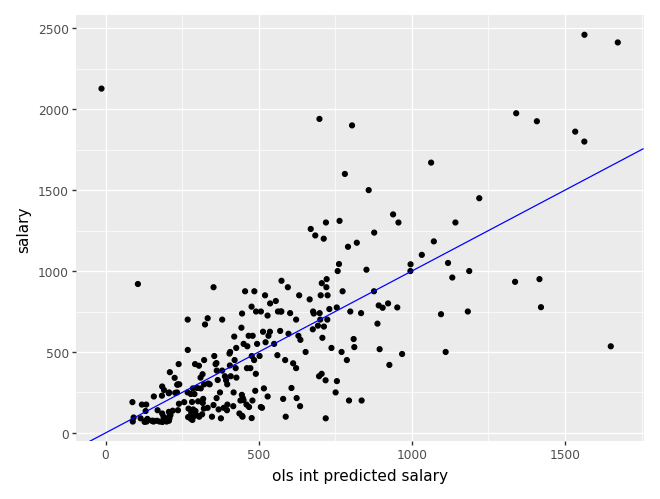

In [52]:
from plotnine import ggplot, aes, geom_point, geom_abline

plot_data = pd.DataFrame({
    "salary": y,
    "ols int predicted salary": ols.predict(XInt)
})

ggplot(plot_data, aes(x="ols int predicted salary", y="salary")) + geom_point() + geom_abline(intercept=0, slope=1, color="blue")

The OLS feature set that includes the interactions between the most significant categorical variable and the five most significant numeric variables has the lowest MSE, which means it is the most accurate. The graph shows that the OLS interaction model is decently accurate.